In [3]:
import os

In [4]:
%pwd

'c:\\Users\\chana\\OneDrive\\Desktop\\MLStudy\\MLFlow\\research'

In [5]:
os.chdir('../')

In [16]:
%pwd

'c:\\Users\\chana\\OneDrive\\Desktop\\MLStudy\\MLFlow'

In [7]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen = True)
class PrepareBaseModelConfig:
    root_dir: Path
    base_model_path: Path
    updated_base_model_path: Path
    params_image_size: list
    params_learning_rate: float
    params_include_top: bool
    params_weights: str
    params_classes: int

    

In [8]:
from src.cnnClassifier.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from src.cnnClassifier.utils.common import read_yaml, create_directories

In [9]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])


    def get_prepare_base_model_config(self) -> PrepareBaseModelConfig:
        config = self.config.prepare_base_model
        
        create_directories([config.root_dir])

        prepare_base_model_config = PrepareBaseModelConfig(
            root_dir=Path(config.root_dir),
            base_model_path=Path(config.base_model_path),
            updated_base_model_path=Path(config.updated_base_model_path),
            params_image_size=self.params.IMAGE_SIZE,
            params_learning_rate=self.params.LEARNING_RATE,
            params_include_top=self.params.INCLUDE_TOP,
            params_weights=self.params.WEIGHTS,
            params_classes=self.params.CLASSES
        )

        return prepare_base_model_config

In [11]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf


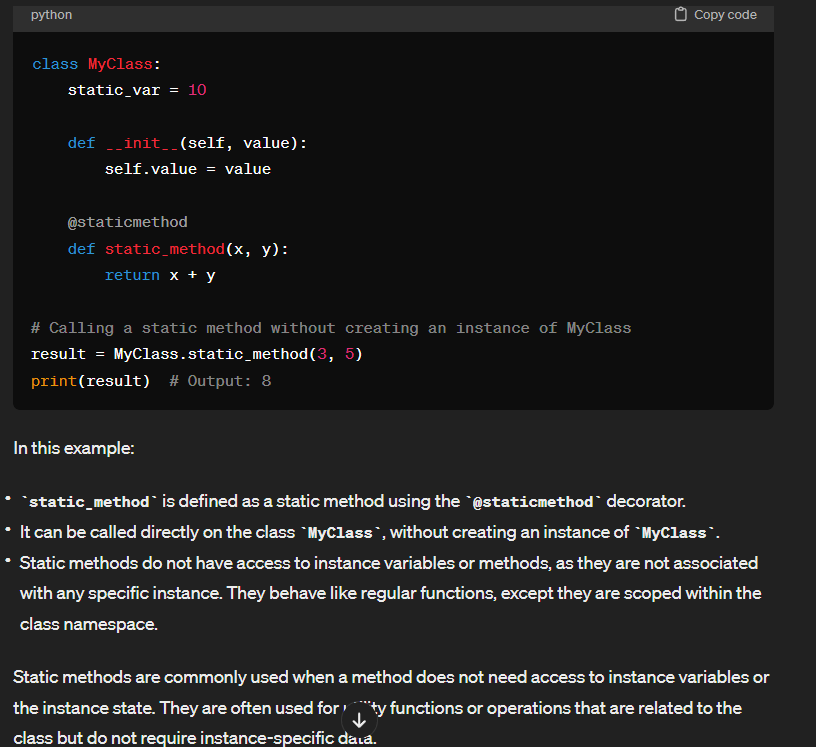

In [17]:
class PrepareBaseModel:
    def __init__(self, config: PrepareBaseModelConfig):
        self.config = config

    def get_base_model(self):
        self.model = tf.keras.applications.vgg16.VGG16(
            input_shape=self.config.params_image_size,
            weights=self.config.params_weights,
            include_top=self.config.params_include_top
        )
        self.save_model(path=self.config.base_model_path, model=self.model)


    @staticmethod
    def _prepare_full_model(model, classes, freeze_all, freeze_till, learning_rate):
        if freeze_all:
            for layer in model.layers:
                model.trainable = False
        elif (freeze_till is not None) and (freeze_till > 0):
            for layer in model.layers[:-freeze_till]:
                model.trainable = False

        flatten_in = tf.keras.layers.Flatten()(model.output)
        prediction = tf.keras.layers.Dense(
            units=classes,
            activation="softmax"
        )(flatten_in)

        full_model = tf.keras.models.Model(
            inputs=model.input,
            outputs=prediction
        )

        full_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=["accuracy"]
        )

        full_model.summary()
        return full_model
    

    def update_base_model(self):
        self.full_model = self._prepare_full_model(
            model=self.model,
            classes=self.config.params_classes,
            freeze_all=True,
            freeze_till=None,
            learning_rate=self.config.params_learning_rate
        )

        self.save_model(path=self.config.updated_base_model_path, model=self.full_model)
    
    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)

In [18]:
try:
    config = ConfigurationManager()
    prepare_base_model_config = config.get_prepare_base_model_config()
    prepare_base_model = PrepareBaseModel(prepare_base_model_config)
    prepare_base_model.get_base_model()
    prepare_base_model.update_base_model()
except Exception as e:
    raise e


[2024-02-23 00:03:43,069: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-02-23 00:03:43,071: INFO: common: yaml file: params.yaml loaded successfully]
[2024-02-23 00:03:43,073: INFO: common: created directory at: artifacts]
[2024-02-23 00:03:43,073: INFO: common: created directory at: artifacts/prepare_base_model]
[2024-02-23 00:03:43,368: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 